# setup

In [6]:
import psycopg2
import numpy as np
import matplotlib.pyplot as plt
import os

In [1]:
# set matplotlib size
def mpl_figsize(scale_factor: int | float) -> tuple[float, float]:
    return 6.4 * scale_factor, 4.8 * scale_factor

def mpl_figsize_xy(scale_factor_x: int | float, scale_factor_y: int | float) -> tuple[float, float]:
    return 6.4 * scale_factor_x, 4.8 * scale_factor_y


In [7]:
# setup connection
conn = psycopg2.connect(
    host='localhost',
    database='cadets_e3',
    user='rosendahl',
)
conn.set_session(readonly=True)
# get cursor
cur = conn.cursor()

In [3]:
# debug
os.system("hostnamectl hostname")
print(f'current working directory: {os.getcwd()}')

vmrosendahl
current working directory: /home/rosendahl/remote_interpreter/dataset/jupyter


# collection of useful queries/values from the data

In [18]:
query = '''
select count(*)
from event;
'''
cur.execute(query)
no_events = cur.fetchall()[0][0]
print(f'number of events: {no_events}')


query = '''
select count(*)
from subject;
'''
cur.execute(query)
no_subjects = cur.fetchall()[0][0]
print(f'number of subjects: {no_subjects}')


query = '''
select count(*)
from principal;
'''
cur.execute(query)
no_principals = cur.fetchall()[0][0]
print(f'number of principals: {no_principals}')

%store no_events
%store no_subjects
%store no_principals

number of events: 41350895
number of subjects: 224629
number of principals: 22
Stored 'no_events' (int)
Stored 'no_subjects' (int)
Stored 'no_principals' (int)


We probably want to predict _properties_map_exec_, what possible categories/classes are there?

In [9]:
query = '''
select distinct e.properties_map_exec, count(e.properties_map_exec) as count 
from event e 
group by e.properties_map_exec;
'''

cur.execute(query)
results_count_distinct_execs = cur.fetchall()

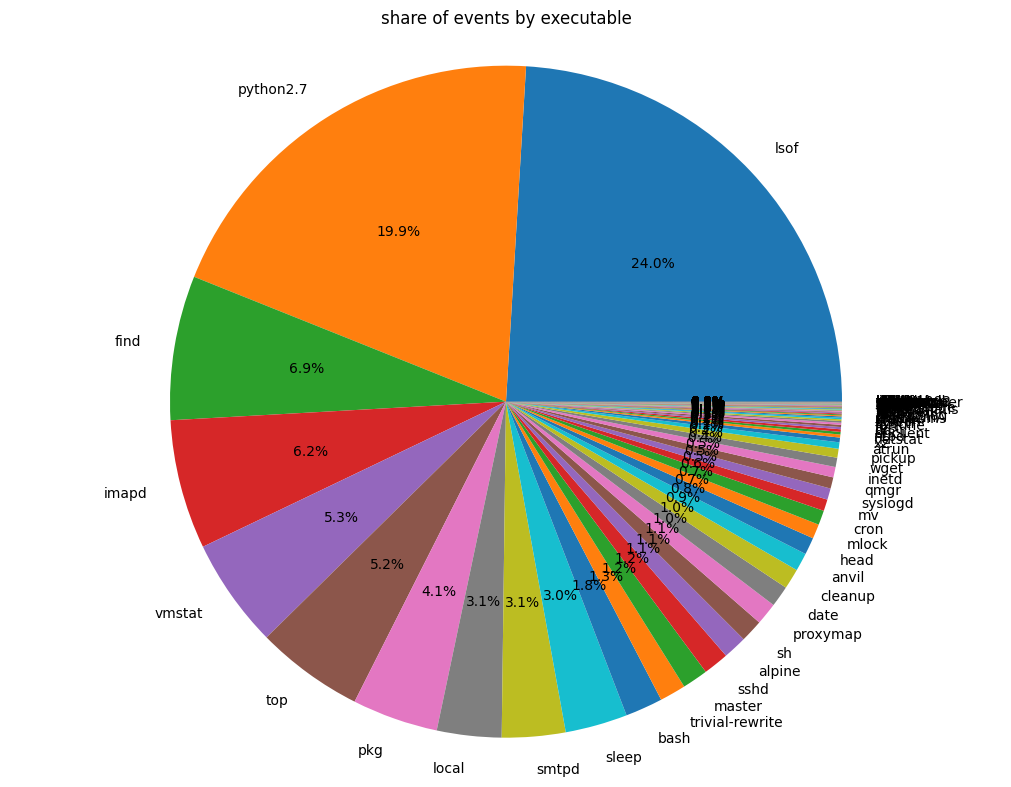

In [10]:
# plot exec distribution

# sort by count
results_count_distinct_execs.sort(key=lambda x: x[1], reverse=True)

labels = [row[0] for row in results_count_distinct_execs]
sizes = [row[1] for row in results_count_distinct_execs]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# resize
fig.set_size_inches(mpl_figsize(2))
plt.title('share of events by executable')
plt.show()

note that 'NULL' is also a possible value, should probably be discarded

this is not the real class distribution, as it does not take sequence length into account  
over/under representation of certain classes might be due to longer/shorter sequences


# filter out subjects with NULL execs
since NULL is a possible value, we should check how many events have a NULL value for _properties_map_exec_  
these events should be discarded for the classification task if there is no way to impute the value TODO: check docs

In [11]:
query = '''
select distinct s.uuid
from event e
join subject s
    on e.subject_uuid = s.uuid
where e.properties_map_exec is null;
'''

cur.execute(query)
result_exec_null_subject_uuids = cur.fetchall()

# convert tuples to list
result_exec_null_subject_uuids = [row[0] for row in result_exec_null_subject_uuids]


print(f'number of events with NULL exec: {len(result_exec_null_subject_uuids)}')
print(f'share of events with NULL exec: {len(result_exec_null_subject_uuids)*100 / no_events :.5f}%')


number of events with NULL exec: 532
share of events with NULL exec: 0.00129%


the share of NULL execs is quite low, so we can probably discard these events

# filter out subjects with duplicate execs
until now, we assumed that subjects do not have duplicate execs (eg. first some sh events, then something different, then sh again)  
minimum sequence len of 1 and other things make me doubt this assumption  

since there is no way to know if a reoccurring exec is a new invocation or a continuation of the previous one, we should discard these subjects  
TODO: check if this is a valid assumption

WARNING: this query will return 40_000_000 rows. all 3 columns are varchar(1024). this is a lot of data (40_000_000 * 1024 * 3 = 120 GB).  
  only run this on the same machine as the database

In [12]:
# find all sequences

query = """
select s.uuid, e.uuid, e.properties_map_exec
from event e
join subject s
    on e.subject_uuid = s.uuid
order by s.uuid, e.sequence_long;
"""

cur.execute(query)
print('query execution complete')

# find all subject.uuids's + event.uuid's where the same exec occurs multiple times with interruptions in between
dup_execs_uuids = []

last_s_uuid = None
last_exec = None
subject_prev_execs = []

for row in cur:
    current_s_uuid, current_e_uuid, current_exec = row
    
    # if new subject, update last subject
    if current_s_uuid != last_s_uuid:
        last_s_uuid = current_s_uuid
        subject_prev_execs.clear()
        last_exec = None
    
    if current_exec != last_exec:
        if current_exec in subject_prev_execs:
            print(f'duplicate exec: {current_exec} for subject {current_s_uuid}. previous execs: {subject_prev_execs}')
            dup_execs_uuids.append((current_s_uuid, current_e_uuid, current_exec))
        subject_prev_execs.append(current_exec)
        last_exec = current_exec

query execution complete
duplicate exec: cp for subject 037E5E95-3C74-11E8-B8CE-15D78AC88FB6. previous execs: ['sh', 'cp', None]
duplicate exec: sendmail for subject 03B5B9F9-3DF4-11E8-A5CB-3FA3753A265A. previous execs: ['sendmail', None]
duplicate exec: None for subject 03B5B9F9-3DF4-11E8-A5CB-3FA3753A265A. previous execs: ['sendmail', None, 'sendmail']
duplicate exec: sendmail for subject 03B5B9F9-3DF4-11E8-A5CB-3FA3753A265A. previous execs: ['sendmail', None, 'sendmail', None]
duplicate exec: sendmail for subject 06C87090-3F1B-11E8-A5CB-3FA3753A265A. previous execs: ['sendmail', None]
duplicate exec: None for subject 06C87090-3F1B-11E8-A5CB-3FA3753A265A. previous execs: ['sendmail', None, 'sendmail']
duplicate exec: sendmail for subject 06C87090-3F1B-11E8-A5CB-3FA3753A265A. previous execs: ['sendmail', None, 'sendmail', None]
duplicate exec: sendmail for subject 08A1738D-3DC8-11E8-A5CB-3FA3753A265A. previous execs: ['sendmail', None]
duplicate exec: None for subject 08A1738D-3DC8-11

In [13]:
# ensure that there are no duplicates in result
dup_execs_uuids = list(set(dup_execs_uuids))
print(f'found {len(dup_execs_uuids)} duplicates')
dup_execs_subjects = set([s_uuid for s_uuid, _, _ in dup_execs_uuids])
print(f'found {len(dup_execs_subjects)} subjects with duplicate execs')

# find out what execs are the duplicate ones and how often they occur
dup_execs = {}
for s_uuid, e_uuid, executable in dup_execs_uuids:
    if executable in dup_execs:
        dup_execs[executable] += 1
    else:
        dup_execs[executable] = 1
        
# sort by count
dup_execs = {k: v for k, v in sorted(dup_execs.items(), key=lambda item: item[1], reverse=True)}
print(dup_execs)

found 984 duplicates
found 542 subjects with duplicate execs
{'cp': 384, None: 221, 'tee': 213, 'sendmail': 116, 'pw': 24, 'ping': 10, 'sh': 10, 'mail.local': 6}


In [14]:
subject_blacklist = set()

# add NULLs 
subject_blacklist.update(result_exec_null_subject_uuids)

# add subjects with duplicate execs
subject_blacklist.update([s_uuid for s_uuid, _, _ in dup_execs_uuids])

print(f'blacklisted subjects: {len(subject_blacklist)}')
print(f'blacklisted subjects share: {len(subject_blacklist)*100 / no_subjects:.5f}%')

no_valid_subjects = no_subjects - len(subject_blacklist)
print(f'number of valid_subjects: {no_valid_subjects}')

blacklisted subjects: 542
blacklisted subjects share: 0.24129%
number of valid_subjects: 224087


In [15]:
# write blacklisted subjects to file. we might need those later / in different notebooks
with open('data/blacklisted_subjects.txt', 'w') as f:
    for s_uuid in subject_blacklist:
        f.write(f'{s_uuid}\n')

# subjects are now filtered, get info about the class distribution again

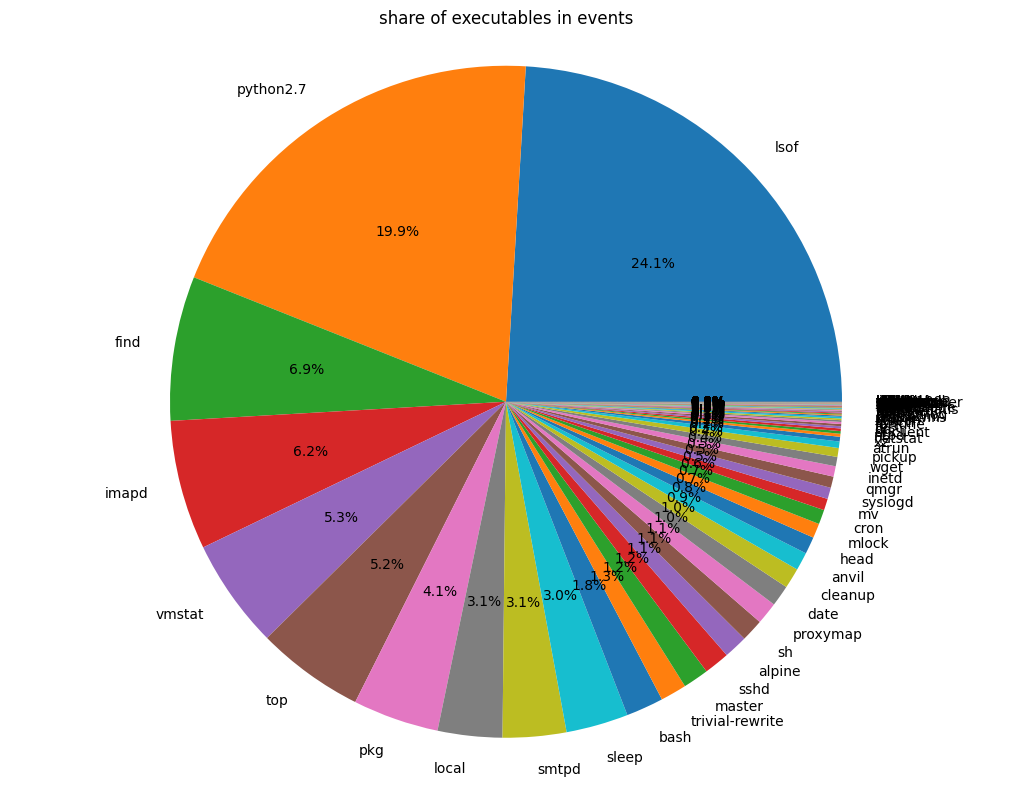

In [14]:
query = '''
select distinct e.properties_map_exec, count(e.properties_map_exec) as count
from event e
join subject s
    on e.subject_uuid = s.uuid
where s.uuid not in %s
group by e.properties_map_exec;
'''

cur.execute(query, (tuple(subject_blacklist),))
results_count_distinct_execs_no_null = cur.fetchall()

# plot exec distribution

# sort by count
results_count_distinct_execs_no_null.sort(key=lambda x: x[1], reverse=True)

labels = [row[0] for row in results_count_distinct_execs_no_null]
sizes = [row[1] for row in results_count_distinct_execs_no_null]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# resize
fig.set_size_inches(mpl_figsize(2))
plt.title('share of executables in events')
plt.show()

this plot does not take sequence size into account  
when ignoring sequence length, how do these proportions change?  
in other words: what are the shares of different events, disregarding sequence length  
this should also be the class distribution 

In [15]:
query = '''
select distinct event_subject.properties_map_exec, count(properties_map_exec) as c
from (select distinct subject.uuid, event.properties_map_exec
from event
join subject
    on event.subject_uuid = subject.uuid
where subject.uuid not in %s
group by subject.uuid, event.properties_map_exec
order by subject.uuid) as event_subject
group by event_subject.properties_map_exec; 
'''

cur.execute(query, (tuple(subject_blacklist),))
classes_occurrence = cur.fetchall()


bash: 159931
sleep: 61840
vmstat: 30877
sh: 23561
imapd: 19082
top: 15618
date: 15469
lsof: 15452
head: 15441
mv: 10940
cron: 10169
master: 8898
mlock: 7817
sshd: 5855
inetd: 4324
atrun: 3116
local: 2630
smtpd: 1691
sysctl: 1567
dd: 1560
unlink: 1551
proxymap: 1237
resizewin: 1167
fortune: 1166
cleanup: 1157
trivial-rewrite: 1153
alpine: 1073
anvil: 899
python2.7: 809
netstat: 432
rm: 432
cat: 331
sendmail: 275
newsyslog: 272
find: 256
mkdir: 239
wget: 196
dmesg: 187
uptime: 184
pkg: 170
pickup: 159
hostname: 134
adjkerntz: 132
dhclient: 104
wc: 99
route: 86
mktemp: 85
sudo: 72
ls: 61
grep: 59
ps: 58
awk: 57
cmp: 51
lockf: 48
mailwrapper: 48
egrep: 33
mail: 29
sed: 28
sort: 28
mount: 26
expr: 25
tty: 24
links: 18
kenv: 17
less: 16
nginx: 16
bzcat: 13
bzip2: 12
cp: 12
df: 12
kill: 12
basename: 11
chkgrp: 11
msgs: 11
xz: 11
screen: 10
tr: 10
csh: 9
ipfstat: 9
jot: 9
uname: 9
pfctl: 8
diff: 7
stat: 7
ipfw: 6
ping: 6
su: 6
tail: 6
test: 6
env: 5
nawk: 5
nohup: 5
postmap: 5
tee: 5
bounce: 4

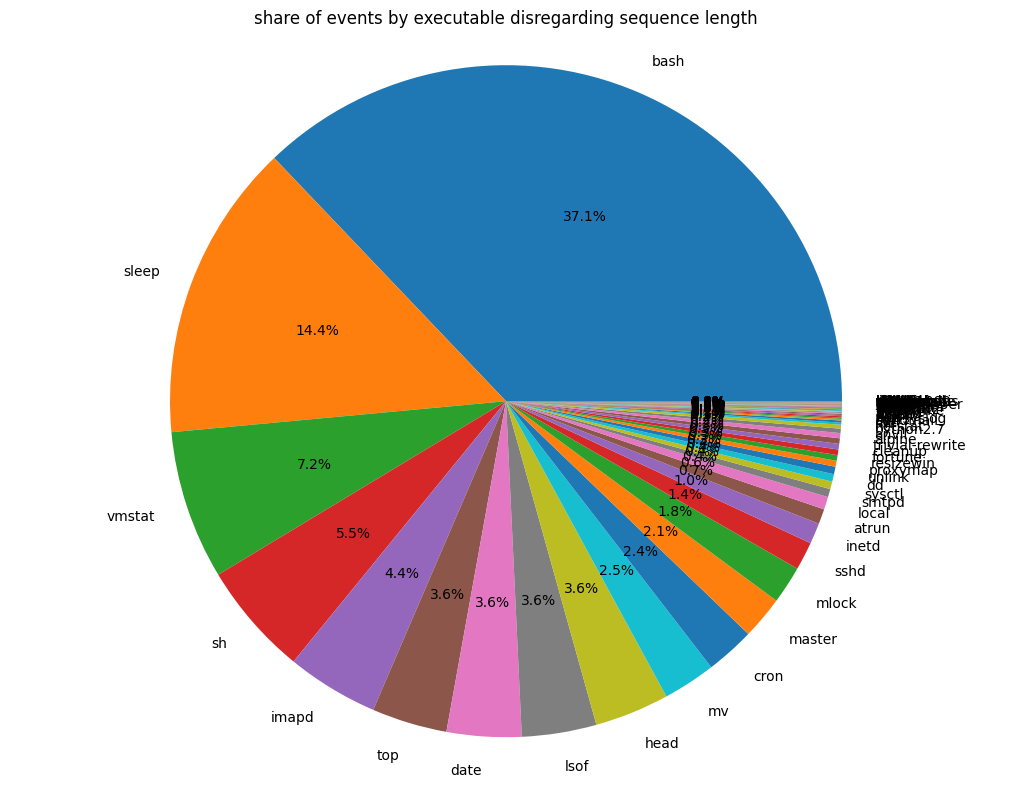

In [16]:
# pie chart plot

# sort by count
classes_occurrence.sort(key=lambda x: x[1], reverse=True)

labels = [row[0] for row in classes_occurrence]
sizes = [row[1] for row in classes_occurrence]

for label, size in zip(labels, sizes):
    print(f'{label}: {size}')

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# resize
fig.set_size_inches(mpl_figsize(2))
plt.title('share of events by executable disregarding sequence length')
plt.show()

# class info

In [17]:
no_classes = len(classes_occurrence)

print(f'number of classes: {no_classes}')
print(f'number of classes with less than 10 sequences: {len([row for row in classes_occurrence if row[1] < 10])}')
print(f'number of classes with less than 100 sequences: {len([row for row in classes_occurrence if row[1] < 100])}')

number of classes: 135
number of classes with less than 10 sequences: 58
number of classes with less than 100 sequences: 91


# sequence info

In [18]:
# find all sequences and their lengths
query = '''
select s.uuid, count(e.uuid) as seq_len, e.properties_map_exec
from event e
join subject s
    on e.subject_uuid = s.uuid
where s.uuid not in %s
group by s.uuid, e.properties_map_exec
order by s.uuid, seq_len;
'''
cur.execute(query, (tuple(subject_blacklist),))
result = cur.fetchall()

In [19]:
# get general sequence info

seq_lens = np.array([row[1] for row in result])
no_sequences = len(seq_lens)

print(f'sequences amount: {no_sequences}')
print(f'min seq len: {np.min(seq_lens)}')
print(f'max seq len: {np.max(seq_lens)}')
print(f'mean seq len: {np.mean(seq_lens)}')
print(f'median seq len: {np.median(seq_lens)}')
print(f'std seq len: {np.std(seq_lens)}')
print(f'var seq len: {np.var(seq_lens)}\n')

# percentage of sequences with length 1
print(f'number of sequences with length <= 10: {len([l for l in seq_lens if l <= 10])}')
print(f'percentage of sequences with length <= 10: {len([l for l in seq_lens if l <= 10])*100 / no_sequences:.5f}%')
print(f'percentage of sequences with length <= 10: {len([l for l in seq_lens if l <= 10])*100 / no_sequences:.5f}%')
print(f'percentage of sequences with length >= 100: {len([l for l in seq_lens if l >= 1000])*100 / no_sequences:.5f}%\n')

# hard filter any sequences with length <= 10
# filtered = np.array([i for i in seq_lens if i > 10])
filtered = np.array(seq_lens)

# find p95 and p5
p = 5
p_l = np.percentile(filtered, p)
p_u = np.percentile(filtered, 100-p)

print(f'percentiles for p{p} and p{100-p} (total: {100-2*p}%): {p_l}, {p_u}\n')

# how many sequences are in range [p_l, p_u]
print(f'number of sequences in range [p_l, p_u]: {len([l for l in filtered if p_l <= l <= p_u])}')
print(f'relative number of sequences in range [p_l, p_u]: {len([l for l in filtered if p_l <= l <= p_u]) / no_sequences:.5f}%\n')

# filter percentiles
filtered = np.array([i for i in filtered if p_l <= i <= p_u])

print(f'sequences amount: {len(filtered)}')
print(f'min seq len: {np.min(filtered)}')
print(f'max seq len: {np.max(filtered)}')
print(f'mean seq len: {np.mean(filtered)}')
print(f'median seq len: {np.median(filtered)}')
print(f'std seq len: {np.std(filtered)}')
print(f'var seq len: {np.var(filtered)}')


sequences amount: 430864
min seq len: 1
max seq len: 3049408
mean seq len: 95.78341657692451
median seq len: 20.0
std seq len: 6245.291822169236
var seq len: 39003669.94405394

number of sequences with length <= 10: 207953
percentage of sequences with length <= 10: 48.26419%
percentage of sequences with length <= 10: 48.26419%
percentage of sequences with length >= 100: 0.46186%

percentiles for p5 and p95 (total: 90%): 1.0, 401.0

number of sequences in range [p_l, p_u]: 409351
relative number of sequences in range [p_l, p_u]: 0.95007%

sequences amount: 409351
min seq len: 1
max seq len: 401
mean seq len: 29.17480353046652
median seq len: 10.0
std seq len: 53.80311576130422
var seq len: 2894.7752656243024


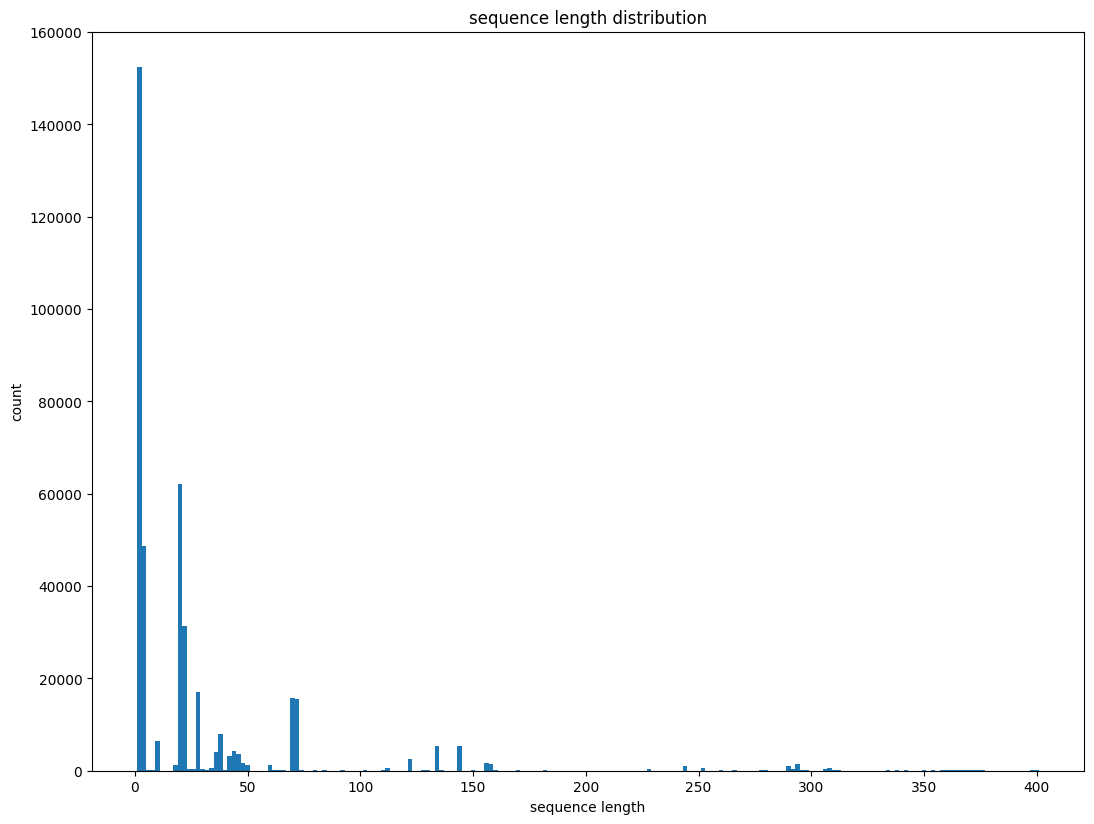

In [22]:
# plot sequence length distribution
fig, ax = plt.subplots()

ax.hist(filtered, bins=200)
ax.set_title('sequence length distribution')
ax.set_xlabel('sequence length')
ax.set_ylabel('count')

# set y log
# ax.set_yscale('log')

# resize
fig.set_size_inches(mpl_figsize(2))
plt.show()

# plot share of execs in sequences

In [23]:
# find share of execs in sequences
query = '''
select event_subject.properties_map_exec, count(properties_map_exec) as c
from (select distinct subject.uuid, event.properties_map_exec
from event
join subject
    on event.subject_uuid = subject.uuid
where subject.uuid not in %s
group by subject.uuid, event.properties_map_exec
order by subject.uuid) as event_subject
group by event_subject.properties_map_exec;
'''

cur.execute(query, (tuple(subject_blacklist),))
execs_in_sequences = cur.fetchall()

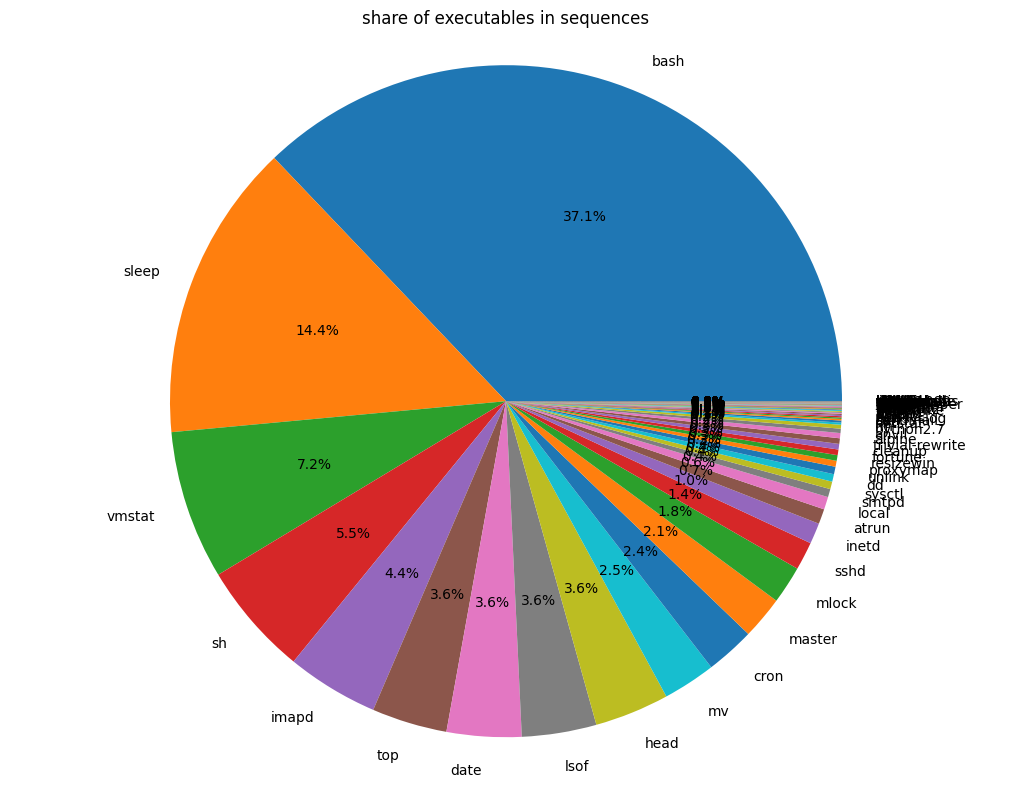

In [24]:
# plot pie chart of share of execs in sequences

# sort by count
execs_in_sequences.sort(key=lambda x: x[1], reverse=True)

labels = [row[0] for row in execs_in_sequences]
sizes = [row[1] for row in execs_in_sequences]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# resize
fig.set_size_inches(mpl_figsize(2))
plt.title('share of executables in sequences')
plt.show()

# plot average sequence length per class

In [25]:
# find average sequence length per class
query = '''
select event_subject.properties_map_exec, avg(seq_len) as avg_seq_len
from (select s.uuid, count(e.uuid) as seq_len, e.properties_map_exec
from event e
join subject s
    on e.subject_uuid = s.uuid
where s.uuid not in %s
group by s.uuid, e.properties_map_exec
order by s.uuid, seq_len) as event_subject
group by event_subject.properties_map_exec;
'''

cur.execute(query, (tuple(subject_blacklist),))
avg_seq_len_per_class = cur.fetchall()

# sort by avg_seq_len
avg_seq_len_per_class.sort(key=lambda x: x[1], reverse=True)

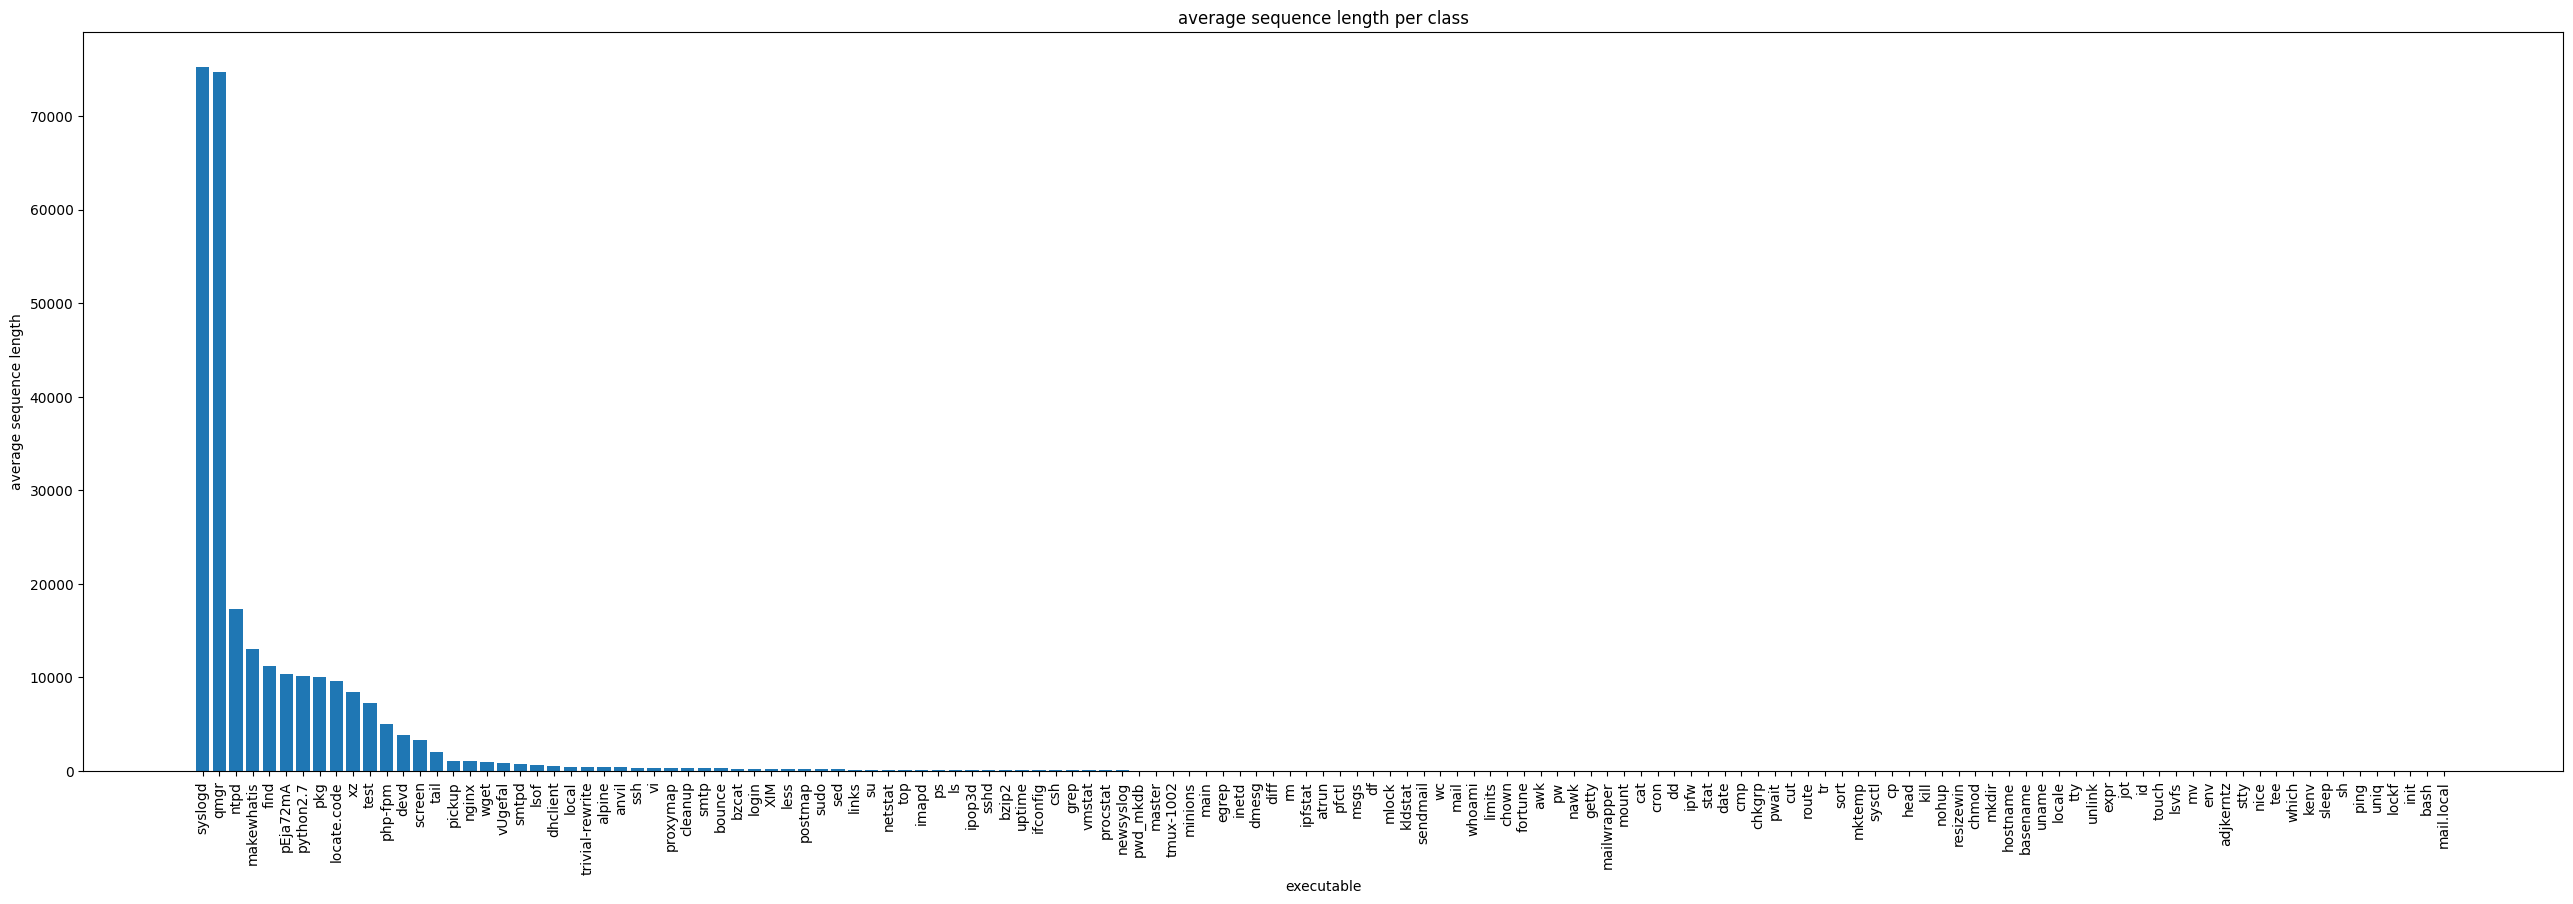

In [26]:
# sort by count
avg_seq_len_per_class.sort(key=lambda x: x[1], reverse=True)

# plot histogram
fig, ax = plt.subplots()

labels = [row[0] for row in avg_seq_len_per_class]
avg_seq_lens = [row[1] for row in avg_seq_len_per_class]

ax.bar(labels, avg_seq_lens)
ax.set_title('average sequence length per class')
ax.set_xlabel('executable')
ax.set_ylabel('average sequence length')

# set x log
# ax.set_yscale('log')

# rotate x labels
plt.xticks(rotation=90)

# resize
fig.set_size_inches(mpl_figsize_xy(5, 2))
plt.show()

note that very many executables have a very low average sequence length

In [27]:
# executables with an average sequence length smaller than 10
print(f'number of classes: {no_classes}')
print(f'number of executables with an average sequence length smaller than 10: {len([row for row in avg_seq_len_per_class if row[1] < 10])}')
print(f'number of executables with an average sequence length smaller than 20: {len([row for row in avg_seq_len_per_class if row[1] < 20])}')
print(f'number of executables with an average sequence length smaller than 100: {len([row for row in avg_seq_len_per_class if row[1] < 100])}')

# get avg sequence length for top 3 classes
for i in range(3):
    print(f'{avg_seq_len_per_class[i][0]}: {avg_seq_len_per_class[i][1]}')
    
# get avg sequence length for bottom 3 classes
for i in range(3):
    print(f'{avg_seq_len_per_class[-i-1][0]}: {avg_seq_len_per_class[-i-1][1]}')
    


number of classes: 135
number of executables with an average sequence length smaller than 10: 3
number of executables with an average sequence length smaller than 20: 8
number of executables with an average sequence length smaller than 100: 90
syslogd: 75214.666666666667
qmgr: 74666.000000000000
ntpd: 17321.000000000000
mail.local: 2.0000000000000000
bash: 4.6444154041430367
init: 8.0000000000000000


# end - close resources

In [25]:
# destroy cursor and connection
cur.close()
conn.close()